## Edge cases need to be fixed for grid assignment

In [193]:
import pandas as pd
%config Completer.use_jedi = False
from matplotlib import pyplot as plt
import numpy as np

In [276]:
def assign_grids(df, n_grids=10):
    '''
    creates an n_grids x n_grids grid and assigns each home in df to its correct grid. 
    Inclusive lower boundary, exclusive upper boundary when calculating grid limits
    
    note: n_grids = 10 will return 100 unique grid points, so it will create 11x11 lines in order to 
    return a 10x10 grid
    
    input
    
    df: should be a pandas DataFrame with addresses, longitude and lattitude values
    n_grids: the number of grids on 1 side of the final desired grid (n x n)
    
    returns the input dataframe with the added 'assigned_grid' column
    '''
    
    
    # create -1 column which will be filled
    df['gridX'] = -1
    df['gridY'] = -1 

    # create grid arrays
    xgrids = np.linspace(df['long'].min(), df['long'].max(),n_grids+1)
    ygrids = np.linspace(df['lat'].min(), df['lat'].max(),n_grids+1)
        
    for xinx, xgrid in enumerate(xgrids[:-1]):
        bool1 = (df['long'] >= xgrid) & (df['long'] < xgrids[xinx+1])
        df.loc[bool1, 'gridX'] = xinx
    for yinx, ygrid in enumerate(ygrids[:-1]):
        bool1 = (df['lat'] >= ygrid) & (df['lat'] < ygrids[yinx+1])
        df.loc[bool1, 'gridY'] = yinx
    
    # assigns string column for easy human viewing 
    df['grid'] = "["+df['gridX'].astype(str) + "," + df['gridY'].astype(str) +"]"
    return df

In [277]:
df = pd.read_csv('poco-extract-long-lat.csv',index_col=0)

inx = df.loc['NO ADDRESS, Port Coquitlam, BC, Canada',:].index
df.drop(inx, inplace=True)

In [298]:
df = assign_grids(df,60)

## Check for unassigned values

In [299]:
inx1 = df['gridX'] == -1
inx2 = df['gridY'] == -1
df[inx1|inx2]

,lat,long,gridX,gridY,grid,checklist
"690 PRAIRIE AVE, Port Coquitlam, BC, Canada",49.270666,-122.732972,-1,44,"[-1,44]","[[-1, 29], [-2, 29], [0, 29], [-1, 30], [-1, 2..."
"4091 LIVERPOOL ST, Port Coquitlam, BC, Canada",49.285671,-122.760585,32,-1,"[32,-1]","[[21, -1], [20, -1], [22, -1], [21, 0], [21, -..."


### Experimenting with a non string replacement for grid column

In [300]:
np.dstack((df['gridX'].values,df['gridY'].values))[0]

array([[ 8, 10],
       [ 5,  7],
       [12,  8],
       ...,
       [13, 47],
       [ 6, 50],
       [12, 48]], dtype=int64)

### now trying to write something to count queries

In [301]:
def corner_case(gridX, gridY,grid_n):
    if (gridX == 0) & (gridY == 0) :
        checklist = [[0, 0], [0, 1], [1, 0], [1, 1]]
        
    elif (gridX == 0) & (gridY == grid_n):
        checklist = [[0, grid_n], [1, grid_n], [0, grid_n-1], [1, grid_n-1]]
        
    elif (gridX == grid_n) & (gridY == 0):
        checklist = [[grid_n, 0], [grid_n, 1], [grid_n-1,0], [grid_n-1, 1]]
        
    elif (gridX == grid_n) & (gridY == grid_n):
        checklist = [[grid_n, grid_n], [grid_n, grid_n-1], [grid_n-1, grid_n], [grid_n-1, grid_n-1]]
        
    return checklist

def edge_case(gridX, gridY, grid_n):
    if gridY == 0:
        if gridX not in [0,grid_n]:
            checklist = [[gridX, gridY], [gridX-1, gridY], [gridX+1, gridY], [gridX, gridY+1], [gridX-1, gridY+1],
                         [gridX+1, gridY+1]]
    elif gridY == grid_n:
        if gridX not in [0,grid_n]:
            checklist = [[gridX, gridY], [gridX-1, gridY], [gridX+1, gridY], [gridX, gridY-1], [gridX-1, gridY-1],
                         [gridX+1, gridY-1]]
    elif gridX == 0:
        if gridY not in [0, grid_n]:
            checklist = [[gridX, gridY], [gridX, gridY-1], [gridX, gridY+1], [gridX+1, gridY], [gridX+1, gridY+1],
                         [gridX+1, gridY-1]]
    elif gridX == grid_n:
        if gridY not in [0, grid_n]:
            checklist = [[gridX, gridY], [gridX, gridY-1], [gridX, gridY+1], [gridX-1, gridY], [gridX-1, gridY+1],
                         [gridX-1, gridY-1]]
    return checklist

def regular_case(gridX, gridY, grid_n):
    checklist = [[gridX, gridY], [gridX-1, gridY], [gridX+1, gridY], [gridX, gridY+1], [gridX, gridY-1], 
                 [gridX-1, gridY-1], [gridX-1, gridY+1], [gridX+1, gridY-1], [gridX+1, gridY+1]]
    return checklist

In [302]:
df['checklist'] = np.nan
df['checklist'] = df['checklist'].astype('object')

In [303]:
for inx,arr in df.iterrows():
    checklist = None
    checklist = regular_case(arr['gridX'],arr['gridY'],20)
    if checklist == None:
        checklist = edge_case(arr['gridX'],arr['gridY'],20)
    if checklist == None:
        checklist = corner_case(arr['gridX'],arr['gridY'],20)
    
    df.loc[inx,'checklist'] = [checklist]

### Now have a list of grids to search for each house

In [304]:
count = 0
for inx,arr in df.iterrows():
    housesToHit = []
    for grid in arr['checklist']:
        xinx = grid[0] == df['gridX']
        yinx = grid[1] == df['gridY']
        housesToHit.append(df.loc[xinx&yinx].index.to_list())
        
    flat_list = [item for sublist in housesToHit for item in sublist] 
    count = count + len(flat_list)
    
        
        

In [305]:
count

622948

In [312]:
df.groupby('grid').count()

,lat,long,gridX,gridY,checklist
grid,,,,,
"[-1,44]",1,1,1,1,1
"[0,1]",1,1,1,1,1
"[0,2]",10,10,10,10,10
"[0,3]",9,9,9,9,9
"[0,4]",4,4,4,4,4
...,...,...,...,...,...
"[9,5]",7,7,7,7,7
"[9,6]",6,6,6,6,6
"[9,7]",11,11,11,11,11


## A plot showing the different groups in Poco ~ doesn't work as written anymore, so don't run or you'll lose the nice pictures

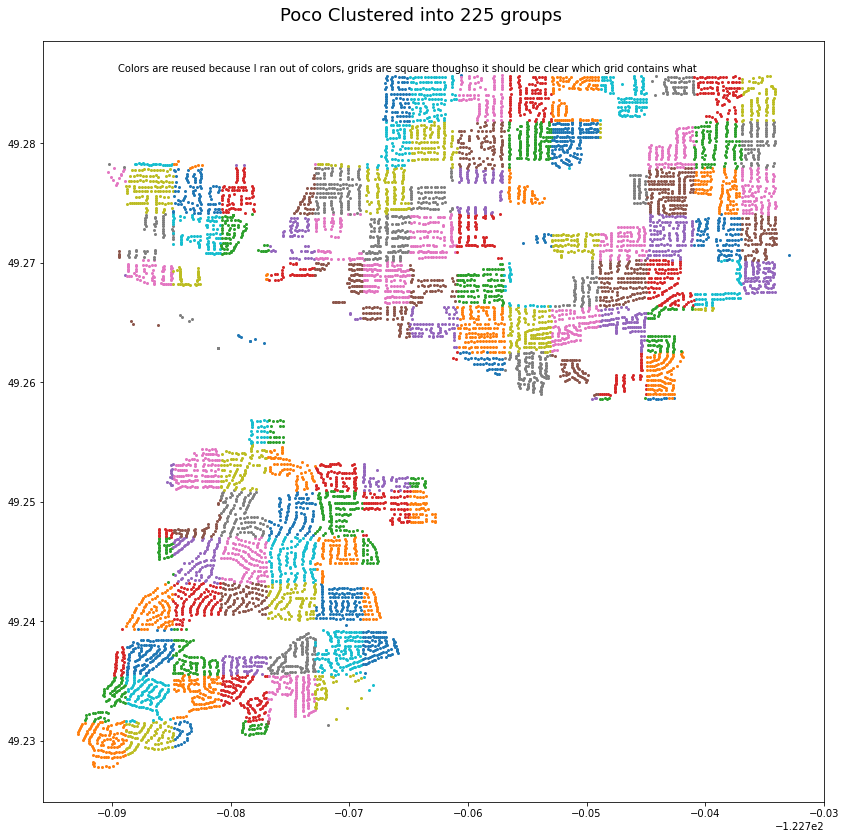

In [251]:
groups = test_df.groupby('assigned_grid')

# Plot

fig, ax = plt.subplots(figsize=(14,14))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.long, group.lat, marker='o', linestyle='', ms=2, label=name)


plt.figtext(.5,.9,'Poco Clustered into 225 groups', fontsize=18, ha='center')
plt.figtext(.2,.85,'Colors are reused because I ran out of colors, grids are square though'+
            'so it should be clear which grid contains what')
plt.show()

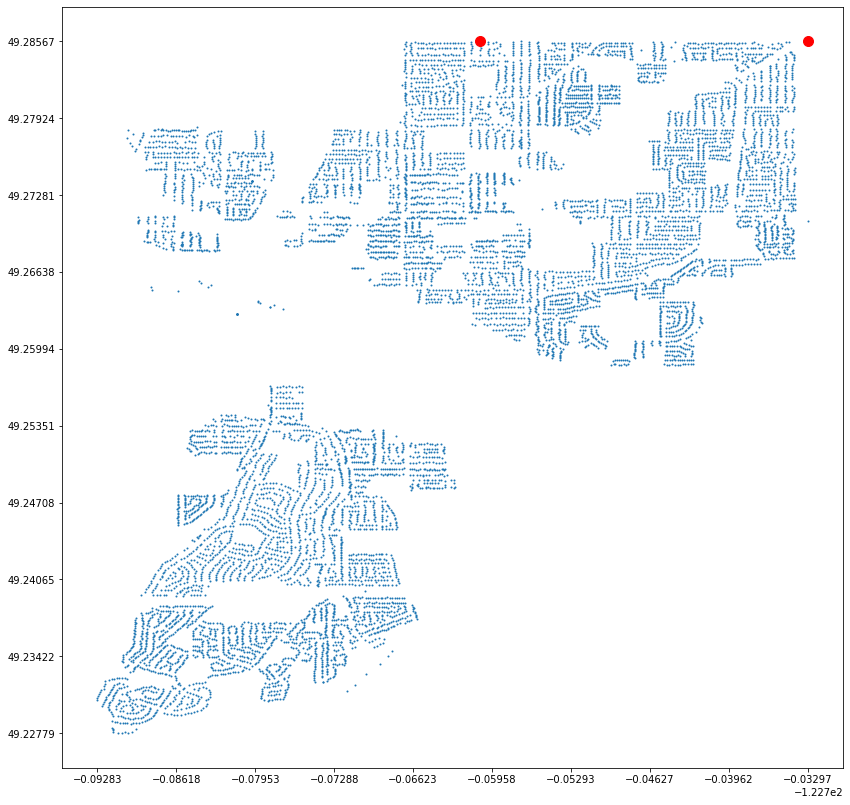

In [459]:
plt.figure(num=1,figsize=(14,14))
plt.plot(df['long'],df['lat'], 'o',markersize=1)
plt.xticks(xgrids)
plt.yticks(ygrids)
plt.plot(test_df.loc['4091 LIVERPOOL ST, Port Coquitlam, BC, Canada', 'long'], 
         df.loc['4091 LIVERPOOL ST, Port Coquitlam, BC, Canada','lat'],'or',markersize=10)

plt.plot(test_df.loc['690 PRAIRIE AVE, Port Coquitlam, BC, Canada', 'long'], 
         df.loc['4091 LIVERPOOL ST, Port Coquitlam, BC, Canada','lat'],'or',markersize=10)
plt.show()
